# Increasing precision
## data augmentation
- flip
- move
- blur
- brighten/darken

## network
hyperparam opt - nb Couches conv, taille filtres

## decrease false positive
increase weight of negatives

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
home = "C:/Users/joanc/PycharmProjects/face_detection/dataset/start_deep/"

## Loading data

In [3]:
df = pd.read_csv(f"{home}posneg.txt", sep=" ", names=["filename", "class"])
df = df.astype(str)
df.head()

,filename,class
0,1/Image000605.pgm,1
1,1/Image000607.pgm,1
2,1/Image000608.pgm,1
3,1/Image000609.pgm,1
4,1/Image000610.pgm,1


In [4]:
df_test = pd.read_csv("dataset/start_deep/testposneg.txt", sep=" ", names=["filename", "class"])
df_test = df_test.astype(str)
df_test.head()

,filename,class
0,"test_images/googlefaces_test/503_1__t0,0_r0_s1...",1
1,"test_images/googlefaces_test/367_0__t0,0_r0_s1...",1
2,"test_images/googlefaces_test/10_0__t0,0_r0_s1.pgm",1
3,"test_images/googlefaces_test/53_0__t0,0_r0_s1.pgm",1
4,"test_images/googlefaces_test/323_0__t0,0_r0_s1...",1


In [5]:
# Changing files from pgm to jpg - run only once
# from PIL import Image
# for file in df_test["filename"]:
#     abs_path = home+file
#     img = Image.open(abs_path)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     if new_name != abs_path:
#         img.save(new_name)

In [6]:
# from PIL import Image
# for file in df["filename"]:
#     abs_path = home+"train_images/" + file
#     img = Image.open(home+"train_images/" + file)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     img.save(new_name)

In [7]:
# renaming .pgm to jpg
def replace_name(name):
    return name.replace(".pgm", ".jpg")
df["filename"] = df["filename"].apply(replace_name)
df_test["filename"] = df_test["filename"].apply(replace_name)

In [8]:
df.head()

,filename,class
0,1/Image000605.jpg,1
1,1/Image000607.jpg,1
2,1/Image000608.jpg,1
3,1/Image000609.jpg,1
4,1/Image000610.jpg,1


### Split train and validation

In [9]:
from sklearn.model_selection import train_test_split

df_train = df
df_val, df_test = train_test_split(df_test, train_size=0.5, random_state=1)

In [10]:
root_dir = home+"train_images/"

In [11]:
from PIL import Image
img = Image.open(root_dir+df["filename"][0])
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
IMG_HEIGHT, IMG_WIDTH

(36, 36)

## Adding weigths based on label

In [12]:
labels, counts = np.unique(df_train["class"], return_counts=True)
weights_labels = {it:(np.sum(counts) / (counts[it])) for it in range(len(labels))}
weights_labels[0] *= (10/11)
weights_labels[1] /= 11
weights_labels

{0: 3.093945016022938, 1: 0.12873524499277164}

In [13]:
((weights_labels[0] * counts[0]) + (weights_labels[1] * counts[1]) ) / np.sum(counts)

1.0

In [14]:
batch_size = 64
train_image_generator = ImageDataGenerator(rescale=1./255,
#                                                   vertical_flip=True,
                                                          width_shift_range=[-4,4],
                                                          height_shift_range=[-4,4],
                                                          horizontal_flip=True,
                                                          rotation_range=5,
                                                          shear_range=0.2,
                                                          zoom_range=0.2,
                                                          brightness_range=[0.8,1.0],
                                            )
train_data_gen = train_image_generator.flow_from_dataframe(df_train, 
                                                           directory=root_dir,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 91720 validated image filenames belonging to 2 classes.


In [15]:
batch_size=32
val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_dataframe(df_val, 
                                                           directory=home,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=False)

Found 3814 validated image filenames belonging to 2 classes.


In [16]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(df_test, 
                                                           directory=home,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=False)

Found 3814 validated image filenames belonging to 2 classes.


In [17]:
sample_training_images, labels = next(train_data_gen)

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

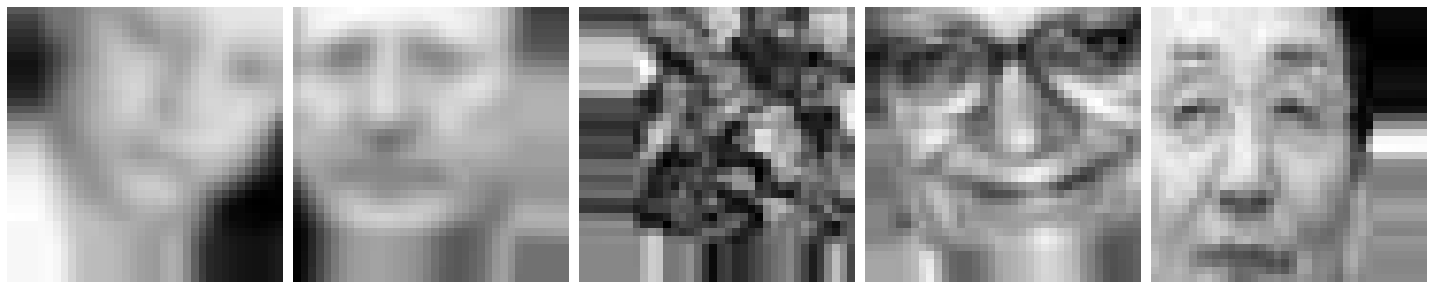

In [19]:
plotImages(sample_training_images[:5])

In [20]:
# bugg fix for some computers
# it makes tensorflow use only the part of the gpu that is needed
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [33]:
dropout_rate = 0.5
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

In [34]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    auc = tf.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = optimizer,
              loss="binary_crossentropy", 
             metrics=["accuracy","AUC"])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

## Finding learning rate

In [36]:
# from lr_finder import LRFinder

# lr_finder = LRFinder()
# _ = model.fit_generator(train_data_gen, epochs=1, callbacks=[lr_finder], verbose=False)
# lr_finder.plot()

In [37]:
## plotting the derviative of the loss in orther to find the best learning rate
# def plot_loss_change(lr_finder, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
#     """
#     Plots rate of change of the loss function.
#     Parameters:
#         sched - learning rate scheduler, an instance of LR_Finder class.
#         sma - number of batches for simple moving average to smooth out the curve.
#         n_skip - number of batches to skip on the left.
#         y_lim - limits for the y axis.
#     """
#     derivatives = [0] * (sma + 1)
#     for i in range(1 + sma, len(lr_finder.lrs)):
#         derivative = (lr_finder.losses[i] - lr_finder.losses[i - sma]) / sma
#         derivatives.append(derivative)
        
#     plt.ylabel("d/loss")
#     plt.xlabel("learning rate (log scale)")
#     plt.plot(lr_finder.lrs[n_skip:], derivatives[n_skip:])
#     plt.xscale('log')
#     plt.ylim(y_lim)

# plot_loss_change(lr_finder, sma=20, n_skip=0)

## Training

In [38]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=None,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[early_stopping],
    class_weight=weights_labels
#     validation_steps=len(df) // batch_size
)

Epoch 1/100
1434/1434 [==============================] - 79s 55ms/step - loss: 0.1820 - accuracy: 0.5573 - AUC: 0.9081 - val_loss: 0.0702 - val_accuracy: 0.9788 - val_AUC: 0.9901
Epoch 2/100
1434/1434 [==============================] - 75s 52ms/step - loss: 0.0935 - accuracy: 0.8134 - AUC: 0.9767 - val_loss: 0.0438 - val_accuracy: 0.9848 - val_AUC: 0.9941
Epoch 3/100
1434/1434 [==============================] - 77s 53ms/step - loss: 0.0681 - accuracy: 0.8712 - AUC: 0.9867 - val_loss: 0.0395 - val_accuracy: 0.9864 - val_AUC: 0.9948
Epoch 4/100
1434/1434 [==============================] - 74s 52ms/step - loss: 0.0561 - accuracy: 0.8960 - AUC: 0.9904 - val_loss: 0.0305 - val_accuracy: 0.9895 - val_AUC: 0.9969
Epoch 5/100
1434/1434 [==============================] - 74s 52ms/step - loss: 0.0498 - accuracy: 0.9103 - AUC: 0.9920 - val_loss: 0.0328 - val_accuracy: 0.9895 - val_AUC: 0.9952
Epoch 6/100
1434/1434 [==============================] - 73s 51ms/step - loss: 0.0416 - accuracy: 0.9260 

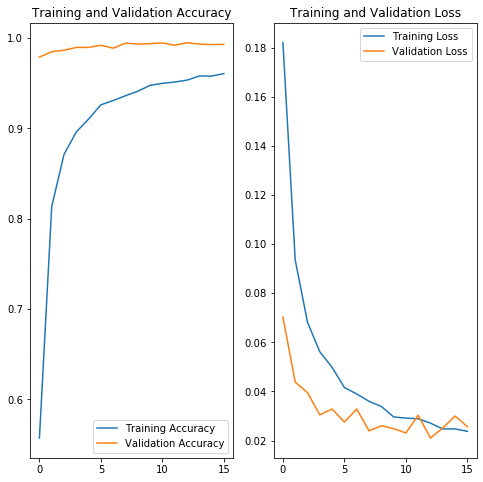

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Metrics

In [40]:
truth = val_data_gen.labels
prediction = model.predict_generator(val_data_gen, workers=0)

In [41]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(truth, prediction))
print(accuracy_score(truth, np.round(prediction)))

0.9977278438972157
0.9929208180388044


# Results

Best val_loss: 0.0209 - val_accuracy: 0.9953 - val_AUC: 0.9969


[9, 9]


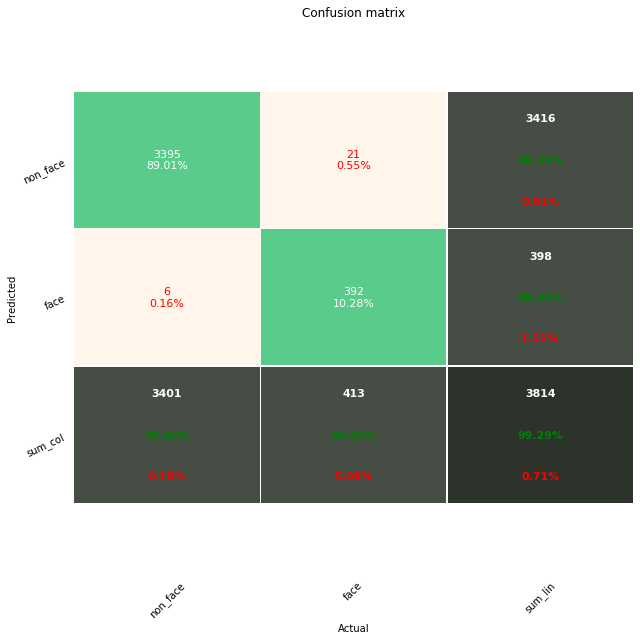

In [46]:
import confusion_matrix

confusion_matrix.plot_confusion_matrix_from_data(truth, prediction[:,0] > 0.5, cmap="Oranges", figsize=[9,9], columns=["non_face", "face"])

In [30]:
prediction

array([[3.2040477e-04],
       [0.0000000e+00],
       [1.5385151e-03],
       ...,
       [7.4505806e-07],
       [1.0000000e+00],
       [3.5111827e-06]], dtype=float32)

In [47]:
model.save("saved_models/face_classifier_weighted.h5")

## Evaluation on test dataset

In [21]:
model = tf.keras.models.load_model("saved_models/face_classifier_weighted.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

In [22]:
truth = test_data_gen.labels
prediction = model.predict_generator(test_data_gen, workers=0)

[9, 9]


C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:166: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:167: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:169: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


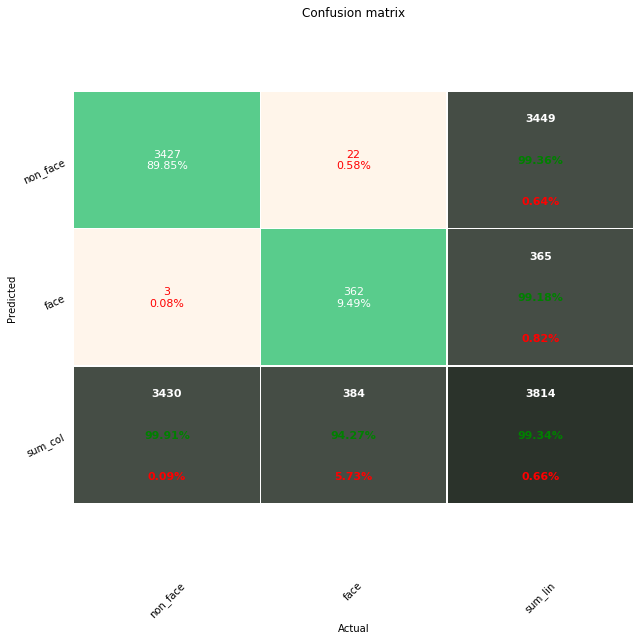

In [23]:
import confusion_matrix

confusion_matrix.plot_confusion_matrix_from_data(truth, prediction[:,0] > 0.5, cmap="Oranges", figsize=[9,9], columns=["non_face", "face"])

[9, 9]


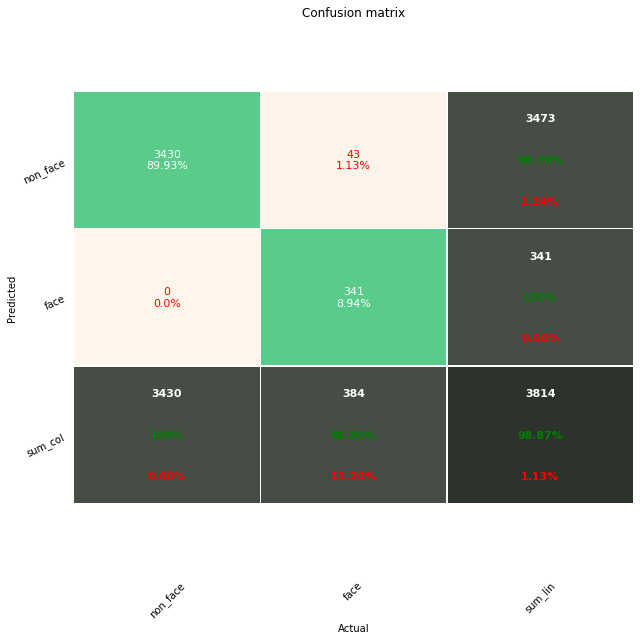

In [41]:
confusion_matrix.plot_confusion_matrix_from_data(truth, prediction[:,0] > 0.9, cmap="Oranges", figsize=[9,9], columns=["non_face", "face"])

Text(0.5, 1.0, '2-class Precision-Recall curve')

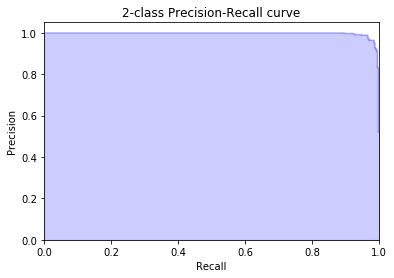

In [32]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, thre = precision_recall_curve(truth, prediction)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

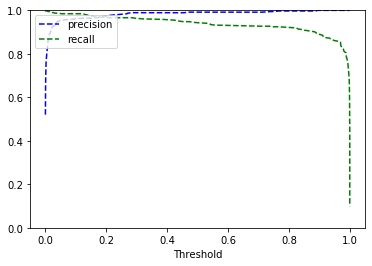

In [33]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(precision, recall, thre)